# Autoencoder

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prepare data

In [2]:
questions = pd.read_csv('../../input/questions.csv')

tag = questions["tags"].str.split(" ", expand = True) 
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']

questions =  pd.concat([questions,tag],axis=1)
questions['tags1'] = pd.to_numeric(questions['tags1'], errors='coerce').fillna(-1).astype('int16')
questions['tags2'] = pd.to_numeric(questions['tags2'], errors='coerce').fillna(-1).astype('int16')
questions['tags3'] = pd.to_numeric(questions['tags3'], errors='coerce').fillna(-1).astype('int16')
questions['tags4'] = pd.to_numeric(questions['tags4'], errors='coerce').fillna(-1).astype('int16')
questions['tags5'] = pd.to_numeric(questions['tags5'], errors='coerce').fillna(-1).astype('int16')
questions['tags6'] = pd.to_numeric(questions['tags6'], errors='coerce').fillna(-1).astype('int16')

all_tags = pd.concat(
    [questions['tags1'], questions['tags2'], questions['tags3'], 
     questions['tags4'], questions['tags5'], questions['tags6']]
)
vocab_size = all_tags.nunique()

print(f'There are {all_tags.nunique()} unique tags (tag value -1 means None)')
print(f'Tag index min: {all_tags.min()}, tag index max: {all_tags.max()}')
print(f'Vocab size = {vocab_size}')

There are 189 unique tags (tag value -1 means None)
Tag index min: -1, tag index max: 187
Vocab size = 189


In [3]:
# extract tags from questions
questions['tags'].fillna(188, inplace=True)
tags = questions['tags'].apply(
    lambda x: np.array([int(v) for v in str(x).split()])
).to_numpy()
print(f'tags sample: {tags[:5]}')

tags sample: [array([ 51, 131, 162,  38]) array([131,  36,  81])
 array([131, 101, 162,  92]) array([131, 149, 162,  29])
 array([131,   5, 162,  38])]


In [4]:
train = pd.read_csv('../../input/train.csv', dtype={'content_id':'int16', 'content_type_id':'int8'}, usecols=['content_id', 'content_type_id'])
train = train[train['content_type_id'] == 0] # take only question-rows
train.rename(columns={'content_id':'question_id'}, inplace=True)
train = train[['question_id']]
train.head()

,question_id
0,5692
1,5716
2,128
3,7860
4,7922


In [5]:
questions['all_tags'] = tags
questions = questions[['question_id', 'all_tags']]
questions.head()

,question_id,all_tags
0,0,"[51, 131, 162, 38]"
1,1,"[131, 36, 81]"
2,2,"[131, 101, 162, 92]"
3,3,"[131, 149, 162, 29]"
4,4,"[131, 5, 162, 38]"


In [6]:
train = train.merge(questions[['question_id', 'all_tags']], how='left', on='question_id')
display(train.head())

corpus = train['all_tags'].to_numpy()
print(f'corpus length: {len(corpus)}')
print(f'corpus sample: {corpus[:4]}')

,question_id,all_tags
0,5692,[151]
1,5716,[168]
2,128,"[131, 149, 92]"
3,7860,"[131, 104, 81]"
4,7922,"[131, 149, 92]"


corpus length: 99271300
corpus sample: [array([151]) array([168]) array([131, 149,  92]) array([131, 104,  81])]


## Build an autoencoder

In [7]:
class MyDataset(Dataset):
    def __init__(self, data, vocab_size):
        super(MyDataset, self).__init__()
        self.data = data
        self.vocab_size = vocab_size
    
    def __len__(self):
        # the corpus size is too large, 
        # we don't need to examine the whole corpus at each epoch
        return 5000000 
    
    def __getitem__(self, idx):
        row = torch.zeros(self.vocab_size)
        idx = np.random.randint(0, len(self.data))
        row[self.data[idx]] = 1
        row = row.to(device)
        return row

dataset = MyDataset(corpus, vocab_size)
dataloader = DataLoader(dataset, batch_size=8192, shuffle=True)

In [8]:
class AE(nn.Module):
    def __init__(self, vocab_size, target_dim):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(vocab_size, 128),
            nn.ReLU(),
            nn.Linear(128, target_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(target_dim, 128),
            nn.ReLU(),
            nn.Linear(128, vocab_size),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x

ae = AE(vocab_size, 4).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters())

### Train

In [9]:
EPOCHS = 5
losses = []

for epoch in range(EPOCHS):
    epoch_loss = []
    ae.train()
    for inp in tqdm(dataloader):
        out = ae(inp)
        loss = criterion(out, inp)
        optimizer.zero_grad()
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    
    curr_loss = np.mean(epoch_loss)
    losses.append(curr_loss)
    
    if curr_loss == min(losses):
        torch.save(ae.state_dict(), 'autoencoder.pt')
    
    print(f'epoch: {epoch}| training MSE: {curr_loss:.7f}')
    

  0%|          | 0/611 [00:00<?, ?it/s]

epoch: 0| training MSE: 0.0199856


  0%|          | 0/611 [00:00<?, ?it/s]

epoch: 1| training MSE: 0.0059035


  0%|          | 0/611 [00:00<?, ?it/s]

epoch: 2| training MSE: 0.0040229


  0%|          | 0/611 [00:00<?, ?it/s]

epoch: 3| training MSE: 0.0035919


100%|██████████| 611/611 [04:54<00:00,  2.07it/s]

epoch: 4| training MSE: 0.0034504


### A glance at the performance

validate autoencoder using 15 random data points (5*3)
for each data point:
+) the title shows the data point id and encoding error
+) the upper bar shows the original data
+) the lower bar shows the uncompressed version


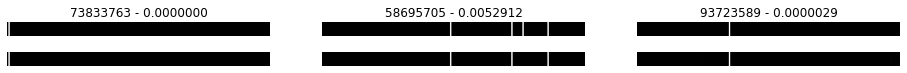

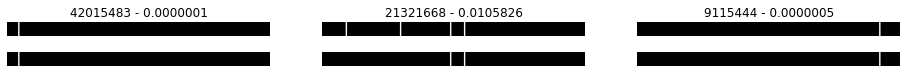

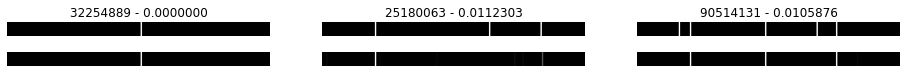

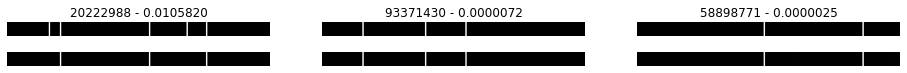

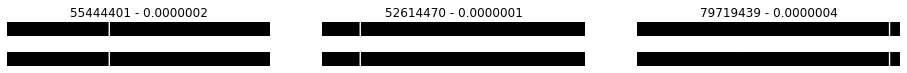

In [10]:
def show(axx, img, tit=''):
    axx.imshow(img.view(1, -1).repeat(10, 1), vmin=0, vmax=1, cmap='gray')
    axx.set_title(tit)
    axx.axis('off')
    
def viz(nrow=5, ncolumn=3):  
    ae.eval()
    print(f'validate autoencoder using {nrow*ncolumn} random data points ({nrow}*{ncolumn})')
    print(f'for each data point:')
    print('+) the title shows the data point id and encoding error')
    print('+) the upper bar shows the original data')
    print('+) the lower bar shows the uncompressed version')
    for ti in range(nrow):
        fig, ax = plt.subplots(2, ncolumn, figsize=(16, 1))
        for i, idx in enumerate(np.random.choice(range(len(corpus)), size=3)):
            example = torch.zeros(vocab_size)
            example[corpus[idx]] = 1
            example = example.to(device)
            out = ae(example).detach()
            err = ((out - example)**2).mean()
            show(ax[0, i], example.cpu(), f'{idx} - {err:.7f}')
            show(ax[1, i], out.cpu())
        plt.savefig('sample_encoding.jpg')
        plt.show()

viz(5)

### Encode and output

In [11]:
encoded = []
for v in tqdm(tags):
    tensor = torch.zeros(vocab_size).to(device)
    tensor[v] = 1
    encoded.append(ae.encode(tensor).cpu().detach().numpy())

questions['compressed_tags'] = encoded
questions = questions[['question_id', 'compressed_tags']]
questions.to_csv('compressed_tags.csv', index=False)
questions.head()

100%|██████████| 13523/13523 [00:03<00:00, 3824.12it/s]


,question_id,compressed_tags
0,0,"[-14.581881, -9.985709, 8.773028, 10.073711]"
1,1,"[-8.093493, -9.205657, 1.788423, 10.297422]"
2,2,"[-20.981781, -8.35818, -3.8366005, 20.523558]"
3,3,"[-5.313623, -10.450474, -9.594804, 12.864284]"
4,4,"[-15.73284, -10.287952, 6.2600574, 12.127032]"
